In [2]:
import numpy as np
import gpstk
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from numba import autojit
from numpy.linalg import norm
%matplotlib inline

In [3]:
#functions for calculate position
@autojit
def apply_earth_rotation_to_svs_position(svs, prs):
    c = 299792458
    we = 7.2921159e-5
    rpos = np.zeros(svs.shape)
    pos = np.array(svs)
    for i in range(len(pos)):
        dt = prs[i]/c
        theta = we*dt
        R = np.array([[np.cos(theta), np.sin(theta),0.],[-np.sin(theta), np.cos(theta),0.],[0.,0.,1.]])
        rpos[i] = R.dot(pos[i])
    svs = np.array(rpos)
    return svs
@autojit
def compute_distances(rc, svs):
    # return np.array( [np.sqrt((rc[0]-sv[0])**2 + (rc[1]-sv[1])**2) for sv in svs] )
    return np.linalg.norm(rc-svs, axis=1) #raiz cuadrada de la suma de los cuadrados de los puntos para medir distancia.
@autojit
def predict_pseudoranges(x, prns_pos, prns_clockbias):
    c = 299792458
    rhos    = compute_distances(x[:3], prns_pos)
    pranges = rhos + x[3]-c*prns_clockbias
    #print "rhos: ",rhos
    #print "pranges: ", pranges
    return rhos, pranges
def compute_least_squares_position(svs, svs_clocks, prs, max_iters=200, apply_earth_rotation=True):

    #if apply_earth_rotation:
    svs = apply_earth_rotation_to_svs_position(svs, prs)
    
    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters): #mientras el delta < 1e-8 y no llegue al maximo de iteraciones
        rhos, pranges = predict_pseudoranges(ri, svs, svs_clocks)
        b = prs - pranges
        A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))
        delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        ri += delta
        i+=1
    return ri, A, b, delta
def to_skyplot(elevation, azimut):
    e = np.array(elevation)
    a = np.array(azimut)
    sx = ((90-e)/90) * np.sin (a * (np.pi/180))
    sy = ((90-e)/90) * np.cos (a * (np.pi/180))
    return (sx,sy)
def compute_raim_position(gps_week, gps_sow, prns, prns_pos, pranges,  bcestore):
    if len(prns)==0 or len(prns_pos)==0:
        return np.array([0,0,0])
    t = gpstk.GPSWeekSecond(gps_week, gps_sow).toCommonTime()
    prnList = [gpstk.SatID(int(i[3:])) for i in prns]
    satVector = gpstk.seqToVector(list(prnList), outtype='vector_SatID')
    rangeVector = gpstk.seqToVector([float(i) for i in pranges])
    noTropModel = gpstk.ZeroTropModel()
    raimSolver = gpstk.PRSolution2()
    raimSolver.RAIMCompute(t, satVector, rangeVector, bcestore, noTropModel)   
    r = np.array([raimSolver.Solution[0], raimSolver.Solution[1], raimSolver.Solution[2]])
    return r


In [4]:
#aira3630 15-->  Problema en la primer observación
#badg3170 15-->  Tiene un problema al calcular la ephemeris de Glonass
#yell0490.16-->  Mas variado en errores y visibilidad de satélites
#mac11000.16-->  Error in GPS Ephemeris 
#gope2440.16-->  Error in GLONASS Ephemeris
#mac12000.16-->  Error in GPS Ephemeris
#jfng2000.16-->  Error GPS grande, Glonass cerca de 7mil
navfile = "glonass/yell0490.16n" 
obsfile = "glonass/yell0490.16o" 
glofile = "glonass/yell0490.16g" 

### FOR <font color='red'>GPS</font>

In [5]:
navHeader, navData = gpstk.readRinex3Nav(navfile)
# setup ephemeris store to look for satellite positions (GPS)
bcestore = gpstk.GPSEphemerisStore()
GPS_LS = navHeader.leapSeconds
print "LEAP SECONDS GPS", GPS_LS
c=0
InitialTimeGPS = bcestore.getInitialTime()
print "TIEMPO INICIAL", bcestore.getInitialTime()
print "TIEMPO FINAL", bcestore.getFinalTime()
for navDataObj in navData:
    c += 1
    ephem = navDataObj.toGPSEphemeris()
    bcestore.addEphemeris(ephem)
    
    if(c==3):
        print bcestore
bcestore.SearchNear()
print "conteo",c
navData.close()

LEAP SECONDS GPS 17
TIEMPO INICIAL 3442448 00000000 0.000000000000000 GPS
TIEMPO FINAL 0000000 00000000 0.000000000000000 GPS
Dump of GPSEphemerisStore (detail level=1):
 BCE table for all satellites has 3 entries; Time span is 2016/02/17 22:00:00 GPS to 2016/02/18 02:00:00 GPS
 Search method is User
Sat G05 has   1 entries; Time span is 2016/02/17 22:00:00 GPS to 2016/02/17 22:00:00 GPS
Sat G07 has   1 entries; Time span is 2016/02/17 22:00:00 GPS to 2016/02/17 22:00:00 GPS
Sat G08 has   1 entries; Time span is 2016/02/17 22:00:00 GPS to 2016/02/17 22:00:00 GPS
END Dump of GPSEphemerisStore (detail level=1)

conteo 231


### FOR <font color='red'>GLONASS</font>

In [6]:
navHeader, navData = gpstk.readRinex3Nav(glofile)
# setup ephemeris store to look for satellite positions (GLONASS)
g = gpstk.GloEphemerisStore()
c=0
Glo_LS = navHeader.leapSeconds
timeSix = []
print "LEAP SECONDS Glonass", Glo_LS

for navDataObj in navData:
    c += 1
    ephem = navDataObj.toGloEphemeris()
    tiempo = ephem.getEphemerisEpoch()
    #tiempo.setTimeSystem(gpstk.TimeSystem('GLO')) #Not necessary, because the navigator file is of Glonass
    #tiempo.addSeconds(-10800)
    xvt = ephem.svXvt(tiempo)
    freq = ephem.getfreqNum()
    g.addEphemeris(navDataObj)
    
    if ephem.getPRNID() == 10:
        timeSix.append(tiempo.getSecondOfDay())
        
    location = gpstk.Position(xvt.x)
    if(ephem.getPRNID() == 10):
        print "PRN",ephem.getPRNID()
        print "pos",xvt
        print "Time Glonass",tiempo.getDays()
        print "FREQ",freq
        print "--------------------------"
print "conteo",c
print "INITIAL TIME", g.getInitialTime()
InitialTimeGlo = g.getInitialTime()
print "FINAL TIME", g.getFinalTime()
FinalTimeGlo = g.getFinalTime()
print "DIFF", g.getFinalTime() - g.getInitialTime()
navData.close()

LEAP SECONDS Glonass 17
PRN 10
pos x:(-2.41444e+07, 405330, 8.30706e+06), v:(1161.62, 24.2834, 3360.89), clk bias:1.41237e-05, clk drift:9.09495e-13, relcorr:2.62037e-09
Time Glonass 2457437.01042
FREQ -7
--------------------------
PRN 10
pos x:(-2.13728e+07, 102728, 1.39585e+07), v:(1884.34, -390.536, 2877.74), clk bias:1.41249e-05, clk drift:9.09495e-13, relcorr:3.22654e-09
Time Glonass 2457437.03125
FREQ -7
--------------------------
PRN 10
pos x:(-1.75057e+07, -1.08244e+06, 1.8533e+07), v:(2366.73, -940.844, 2171.93), clk bias:1.41265e-05, clk drift:0, relcorr:3.57283e-09
Time Glonass 2457437.05208
FREQ -7
--------------------------
PRN 10
pos x:(-1.30287e+07, -3.3036e+06, 2.16759e+07), v:(2557.24, -1522.97, 1297.43), clk bias:1.41273e-05, clk drift:0, relcorr:3.63083e-09
Time Glonass 2457437.07292
FREQ -7
--------------------------
PRN 10
pos x:(-8.47901e+06, -6.51605e+06, 2.31426e+07), v:(2450.45, -2023.62, 321.432), clk bias:1.41285e-05, clk drift:0, relcorr:3.39725e-09
Time Glo

In [7]:
print timeSix
print InitialTimeGlo + timeSix[0]
InitialTimeGPS.setTimeSystem(gpstk.TimeSystem('GLO'))
Diferencia = InitialTimeGPS-InitialTimeGlo
print Diferencia
print 900./60.,29700./60,31500./60.,33300./60.,35100./60.
print 34375-1042

[900.0, 2700.0, 4500.0, 6300.0, 8100.0, 9900.0, 11700.0, 13500.0, 15300.0, 17100.0, 18900.0, 44100.0, 45900.0, 47700.0, 49500.0, 51300.0, 53100.0, 54900.0, 80100.0, 81900.0, 83700.0, 85500.0]
2457437 01800000 0.000000000000000 GLO
85104949500.0
15.0 495.0 525.0 555.0 585.0
33333


### <font color='red'>OBSERVATION</font> DATA

In [8]:
observation_types=["P1", "P2", "L1", "L2"]

Elevations = []
Azimuths = []
TimeOfDay = []

A_Glonass = []
A_GPS = []
A_All = []

prefix = ""
c = 299792458.
counter=0
gl = 0
observations = 2000 # Las primeras "450" observaciones, para mas observaciones cambiar el número.

obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
print obsHeader.stringFirstTime, obsHeader.firstObs
#real position (of observer)
real_pos = obsHeader.antennaPosition[0], obsHeader.antennaPosition[1], obsHeader.antennaPosition[2]
print "real position",real_pos
#this code for know if have the observation P1,P2,L1,L2, if have not, I can not calculate the position
requested_obstypes = observation_types
obsidxs = []
obstypes = []
obsdefs = np.array([i for i in obsHeader.R2ObsTypes])
for i in requested_obstypes:
    w = np.where(obsdefs==i)[0]
    if len(w)!=0:
        obsidxs.append(w[0])
        obstypes.append(i)
    else:
        print ("WARNING! observation `"+i+"` no present in file")
print "observation types",obsidxs, obstypes


obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
#obsObject = obsData.next() #just for the first observation
for obsObject in obsData: #round the data
    counter += 1
    if(counter<=observations and counter>5):
        
        GPSSat = []
        GPSPos = []
        GPSClockBias = []
        GPSRelatCorr = []
        GPSP1 = []

        GloSat = []
        GloPos = []
        GloClockBias = []
        GloRelatCorr = []
        GloP1 = []
        
        Elevations = []
        Azimuths = []
        
        #counter += 1
        TimeOfDay.append(obsObject.time.getSecondOfDay())
        for satID, datumList in obsObject.obs.iteritems():
                
            
                #--------------------GPS----------
            if(satID.system == satID.systemGPS):
                GPSSat.append(str(satID))
                eph   = bcestore.findEphemeris(satID, obsObject.time) #bcestore is a objetc for the ephemeris   
                #P1 distance in meters
                obsdict = {}
                for i in obstypes:
                    obsdict[i]=[]
                for i in range(len(obsidxs)): #get it all the distance of each type of observation
                    obsdict[obstypes[i]].append(obsObject.getObs(satID, obsidxs[i]).data)
                    #print obsdict #, but I wanna calculate it
                    #obsidxs[0] = 0,  P1
                P1 = obsObject.getObs(satID, obsidxs[0]).data
                
                GPSP1.append(P1)
                
                svTime = obsObject.time - P1/c #Time of signal transmission at satellite
                #print "SEC GPS*",obsObject.time.getSecondOfDay(),"TIME",obsObject.time,"*"
                svXvt = eph.svXvt(svTime)
                svTime += - svXvt.getClockBias() + svXvt.getRelativityCorr() #minus error clock_bias, plus 
                svXvt = eph.svXvt(svTime)

                pos_prn = [svXvt.x[0], svXvt.x[1], svXvt.x[2]]

                elevGPS = obsHeader.antennaPosition.elvAngle(svXvt.getPos())
                azimGPS = obsHeader.antennaPosition.azAngle(svXvt.getPos())
                
                #if(elevGPS >10):
                GPSPos.append(pos_prn)
                GPSClockBias.append(svXvt.getClockBias())
                GPSRelatCorr.append(svXvt.getRelativityCorr())

                A_GPS.append([GPSSat,GPSP1,GPSPos,GPSClockBias,elevGPS,azimGPS])
                A_All.append([GPSSat,GPSP1,GPSPos,GPSClockBias,elevGPS,azimGPS])
                #--------------------GLONASS------------------
            elif(satID.system == satID.systemGlonass):
                gl += 1
                GloSat.append(str(satID))
                #P1 distance in meters
                obsdict = {}
                for i in obstypes:
                    obsdict[i]=[]
                for i in range(len(obsidxs)): #get it all the distance of each type of observation
                    obsdict[obstypes[i]].append(obsObject.getObs(satID, obsidxs[i]).data)

                '''In order to avoid misunderstandings and to keep the code observations within
                    the format fields, the pseudoranges must be corrected in this case as follows:

                      PR(GPS) := PR(GPS) + c * leap_seconds   if generated with a receiver clock
                                                              running in the GLONASS time frame

                      PR(GLO) := PR(GLO) - c * leap_seconds   if generated with a receiver clock
                                                              running in the GPS time frame'''

                
                P1 = obsObject.getObs(satID, obsidxs[0]).data
                '''- the raw GPS pseudoranges will show the negative number of leap seconds
                      between GPS time and GLONASS time if the receiver clock is running in the
                      GLONASS time frame'''
                
                if(obsHeader.leapSeconds>0):
                    P = P1 - (c * Glo_LS) #PR(GLO) := PR(GLO) - c * leap_seconds
                    
                
                GloTime = obsObject.time #Time of the observation
                GloTime.setTimeSystem(gpstk.TimeSystem('GLO')) #Trasform time of the observation to GLONASS type
                
                svTime = GloTime - P1/c  # Time of signal transmission at satellite
                
                svTime += - svXvt.getClockBias()  -17#- svXvt.getRelativityCorr() #minus error clock_bias, 
                '''In the GLONASS system, 'clkbias' already includes the relativistic
                     correction, therefore we must substract the late from the former.
                ORIGINAL CODE: sv.relcorr = sv.computeRelativityCorrection();
                ORIGINAL CODE: sv.clkbias = clkbias + clkdrift * (epoch - ephTime) - sv.relcorr;
                ''' 
                if counter < 7:
                    print "Inicial",InitialTimeGlo
                    print "Diferencial",svTime - InitialTimeGlo
                    print "Boundaries In-Fin", (InitialTimeGlo - 900.) > svTime or (FinalTimeGlo + 900.) < svTime 
                    j=0
                    for secsSix in timeSix:
                        
                        prueba = InitialTimeGlo + secsSix
                        if  prueba > svTime:
                            j += 1
                            break 
                    
                    tiempoAntes = InitialTimeGlo + timeSix[j-1] - 900.
                    tiempoDespues = InitialTimeGlo + timeSix[j-1] + 900.
                    print "T. Ant ",tiempoAntes, (tiempoAntes)-svTime,(tiempoAntes) > svTime
                    
                    print "Actual ",svTime
                    print "T. Des ",tiempoDespues,(tiempoDespues)-svTime,(tiempoDespues) < svTime 
                    print "P",P,"P1",P1
                    print "GLOTIME",GloTime
                    print "----------------"
                
                eph   = g.findEphemeris(satID,svTime) 
                svXvt = eph.svXvt(svTime) #with RungeKutta Method (4RK) 
                
                pos_prn = [svXvt.x[0], svXvt.x[1], svXvt.x[2]]

                elevG = obsHeader.antennaPosition.elvAngle(svXvt.getPos())
                azimG = obsHeader.antennaPosition.azAngle(svXvt.getPos())
                Elevations.append(elevG)
                Azimuths.append(azimG)
                
                GloP1.append(P1)
                GloPos.append(pos_prn)
                GloClockBias.append(svXvt.getClockBias())
                GloRelatCorr.append(svXvt.getRelativityCorr())
                
                A_Glonass.append([GloSat,GloP1,GloPos,GloClockBias,Elevations,Azimuths])
                A_All.append([GloSat,GloP1,GloPos,GloClockBias,Elevations,Azimuths])
            
        #print "Observation:",counter," TIEMPO OBSERVACION ",obsObject.time, "#PRNs - GPS's ",len(GPSSat),"Glo ",len(GloSat)

names=["PRN","P1", "POS", "CLOCK","ELEV","AZIM"]
A_GPS = pd.DataFrame(A_GPS, columns=names)
A_Glonass = pd.DataFrame(A_Glonass, columns=names)
A_All = pd.DataFrame(A_All, columns=names) 
        
                

TIME OF FIRST OBS 02/18/2016 00:00:00 GPS
real position (-1224452.4, -2689216.0, 5633638.2)
observation types [4, 5, 0, 1] ['P1', 'P2', 'L1', 'L2']
Inicial 2457437 00900000 0.000000000000000 GLO
Diferencial -767.076943879
Boundaries In-Fin False
T. Ant  2457437 00900000 0.000000000000000 GLO 767.076943879 True
Actual  2457437 00132923 0.000056120502497 GLO
T. Des  2457437 02700000 0.000000000000000 GLO 2567.07694388 False
P -5073433843.57 P1 23037942.43
GLOTIME 2457437 00150000 0.000000000000000 GLO
----------------
Inicial 2457437 00900000 0.000000000000000 GLO
Diferencial -767.067805376
Boundaries In-Fin False
T. Ant  2457437 00900000 0.000000000000000 GLO 767.067805376 True
Actual  2457437 00132932 0.000194623594504 GLO
T. Des  2457437 02700000 0.000000000000000 GLO 2567.06780538 False
P -5076169412.78 P1 20302373.219
GLOTIME 2457437 00150000 0.000000000000000 GLO
----------------
Inicial 2457437 00900000 0.000000000000000 GLO
Diferencial -767.070672315
Boundaries In-Fin False
T. An

### Position for GPS - <font color='red'>Last Observation</font>

In [9]:
print GPSSat # GPS
p1 = np.array(GPSP1)
pos = np.array(GPSPos)
clock = np.array(GPSClockBias)

['GPS 1', 'GPS 8', 'GPS 10', 'GPS 11', 'GPS 14', 'GPS 17', 'GPS 18', 'GPS 22', 'GPS 24', 'GPS 28']


In [10]:
ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)

In [11]:
print "real                  ", real_pos
print "LS computed           ", ls_computed_pos[:3]
print "LS error              ", np.linalg.norm(ls_computed_pos[:3] - real_pos)," distance"
c = 299792458.
print "receiver clock bias   ", ls_computed_pos[3]/c, "secs ==", ls_computed_pos[3], "meters"
print "satellite clock biases", clock

real                   (-1224452.4, -2689216.0, 5633638.2)
LS computed            [ -131308.01705433  6757150.19457508  -267377.8574021 ]
LS error               11191549.912  distance
receiver clock bias    -0.0261802515122 secs == -7848641.95191 meters
satellite clock biases [  1.20887472e-05  -2.43697642e-05   4.17050372e-05  -6.32920448e-04
   2.32299060e-06  -2.00878794e-04   4.84858978e-04   3.95110575e-04
  -1.25956371e-05   5.03324381e-04]


### Position for <font color='red'>GLONASS</font>

In [12]:
print GloSat # Glonass
p1 = np.array(GloP1)
pos = np.array(GloPos)
clock = np.array(GloClockBias)

['GLONASS 3', 'GLONASS 4', 'GLONASS 5', 'GLONASS 13', 'GLONASS 14', 'GLONASS 19', 'GLONASS 20', 'GLONASS 21']


In [13]:
ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)

In [14]:
print "real                  ", real_pos
print "LS computed           ", ls_computed_pos[:3]
print "LS error              ", np.linalg.norm(ls_computed_pos[:3] - real_pos)," distance"
c = 299792458.
print "receiver clock bias   ", ls_computed_pos[3]/c, "secs ==", ls_computed_pos[3], "meters"
print "satellite clock biases", clock

real                   (-1224452.4, -2689216.0, 5633638.2)
LS computed            [-1224457.81938994 -2689220.88386432  5633653.11978672]
LS error               16.6078883015  distance
receiver clock bias    -2.36015483157e-05 secs == -7075.56618216 meters
satellite clock biases [  6.27235910e-05   1.57780244e-04  -1.79507892e-06   1.04494929e-05
   2.83250135e-04  -1.48452301e-04  -2.20018780e-04   5.15491031e-05]


### Position for <font color='blue'>GPS</font> -  <font color='red'>All Observations</font>

In [15]:
positionGPS = []
erroresGPS = []
NormErroesGPS = []
vistos = []
Elevations = []
c = 299792458.
SumError = 0.
posXYGPS = []
sumaErroresMayoDiezmil = 0

for i in range (0, observations):
    #print A_GPS.PRN[i]
    p1 = np.array(A_GPS.P1[i])
    pos = np.array(A_GPS.POS[i])
    clock = np.array(A_GPS.CLOCK[i])
    vistos.append(len(A_GPS.PRN[i]))
    
    #print A_GPS.ELEV[i]
    
    
    Elevations.append(A_GPS.ELEV[i])
    ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)
    ls_error = np.linalg.norm(ls_computed_pos[:3] - real_pos)
    
    if ls_error<10000.: #quitar los errores de posición superiores a 10mil
        posXYGPS.append([ls_computed_pos[:1]-real_pos[:1],ls_computed_pos[1:2]-real_pos[1:2]])
        pos_cpu = ls_computed_pos[:3]
        
        reciverBias = ls_computed_pos[3]/c
        SumError += ls_error
        positionGPS.append([pos_cpu,ls_error,reciverBias])
        erroresGPS.append(ls_error)
    else:
        sumaErroresMayoDiezmil += 1
    
        #NormErroesGPS.append(ls_error)

names=["X","GPS" ]
posXYGPS = pd.DataFrame(posXYGPS, columns=names)        
print "Average Error Position for GPS: ", SumError/observations, "[meters]"
print "Maximum Error: ",max(erroresGPS), "[meters]"
print "Minimum Error: ",min(erroresGPS), "[meters]"
print "Errores de posición superiores a 10mil: ", sumaErroresMayoDiezmil
names = ["PosComputed","PosError","ClockBias"]
positionGPS = pd.DataFrame(positionGPS,columns=names)
print "Average Error: ", reduce(lambda x, y: x + y, erroresGPS) / len(erroresGPS), "how much: ",len(erroresGPS)

Average Error Position for GPS:  20.7223271426 [meters]
Maximum Error:  35.8473345096 [meters]
Minimum Error:  11.3119435441 [meters]
Errores de posición superiores a 10mil:  282
Average Error:  24.1237801427 how much:  1718


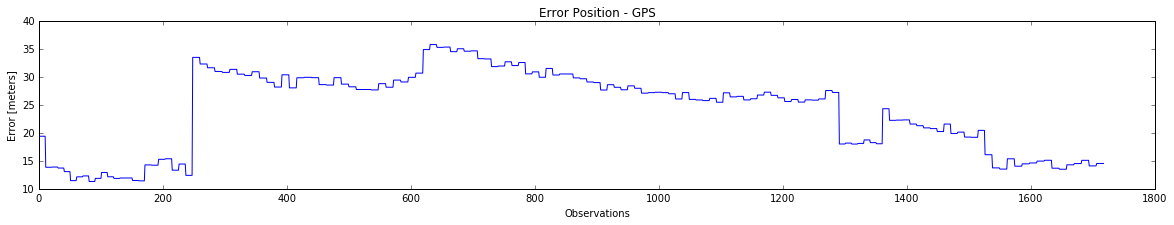

In [16]:
fig=plt.figure(figsize=(20,3))
plt.plot(erroresGPS)
plt.ylabel("Error [meters]")
plt.xlabel("Observations")
plt.title('Error Position - GPS')

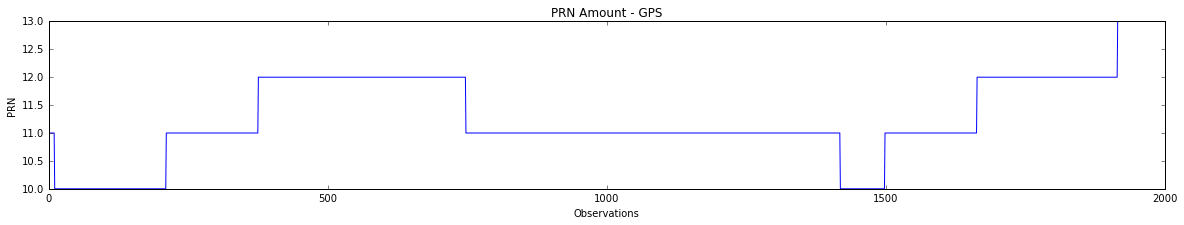

In [17]:
fig=plt.figure(figsize=(20,3))
plt.plot(vistos)
plt.ylabel("PRN")
plt.xlabel("Observations")
plt.title('PRN Amount - GPS')

### Position for <font color='blue'>GLONASS</font> -  <font color='red'>All Observations</font>

In [18]:
positionGlo = []
erroresGlo = []
c = 299792458.
SumError = 0.
vistos = []
ElevationsR = []
posXYGlo = []
sumaErroresMayoDiezmil = 0

for i in range (0, observations):
    #print A_GPS.PRN[i]
    p1 = np.array(A_Glonass.P1[i])
    pos = np.array(A_Glonass.POS[i])
    clock = np.array(A_Glonass.CLOCK[i])
    vistos.append(len(A_Glonass.PRN[i]))
    
    ElevationsR.append(A_Glonass.ELEV[i])
    
    ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)
    
    
    pos_cpu = ls_computed_pos[:3]
    
    ls_error = np.linalg.norm(ls_computed_pos[:3] - real_pos)
    
    if ls_error<10000.: #quitar los errores de posición superiores a 10mil
        posXYGlo.append([ls_computed_pos[:1]-real_pos[:1],ls_computed_pos[1:2]-real_pos[1:2]])
        reciverBias = ls_computed_pos[3]/c
        SumError += ls_error
        positionGlo.append([pos_cpu,ls_error,reciverBias])
        erroresGlo.append(ls_error)
    else:
        sumaErroresMayoDiezmil += 1
        
names=["X","GLONASS" ]
posXYGlo = pd.DataFrame(posXYGlo, columns=names)

print "Maximum Error: ",max(erroresGlo), "[meters]"
print "Minimum Error: ",min(erroresGlo), "[meters]"
print "Errores de posición superiores a 10mil: ", sumaErroresMayoDiezmil
names = ["PosComputed","PosError","ClockBias"]
positionGlo = pd.DataFrame(positionGlo,columns=names)
print "Average Error Position for GLONASS: ", SumError/len(erroresGlo), "[meters]","how much: ",len(erroresGPS)

Maximum Error:  37.670066904 [meters]
Minimum Error:  11.017013102 [meters]
Errores de posición superiores a 10mil:  0
Average Error Position for GLONASS:  22.3038512625 [meters] how much:  1718


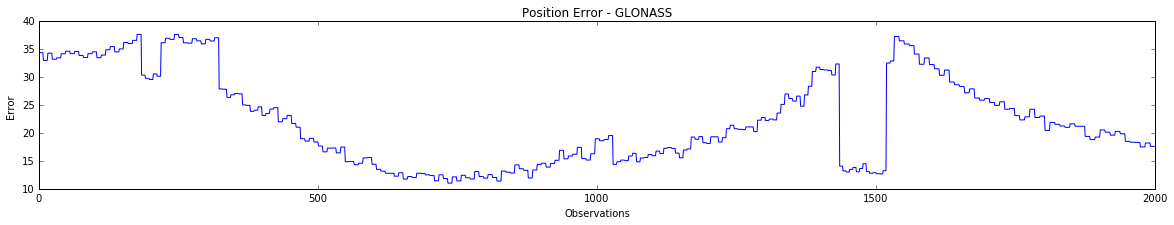

In [19]:
fig=plt.figure(figsize=(20,3))
plt.plot(erroresGlo)
plt.ylabel("Error ")
plt.xlabel("Observations")
plt.title('Position Error - GLONASS')

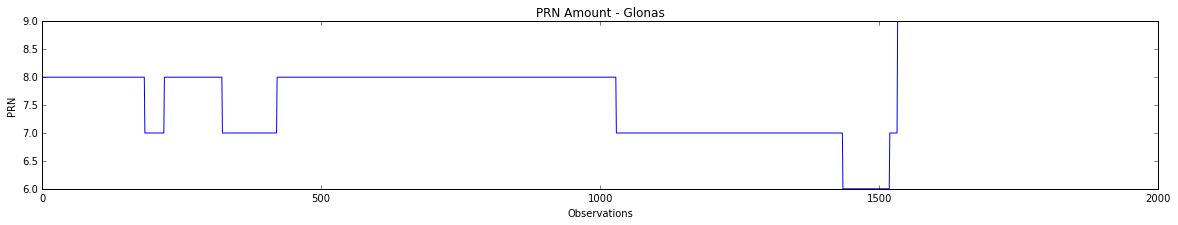

In [20]:
fig=plt.figure(figsize=(20,3))
plt.plot(vistos)
plt.ylabel("PRN")
plt.xlabel("Observations")
plt.title('PRN Amount - Glonas')

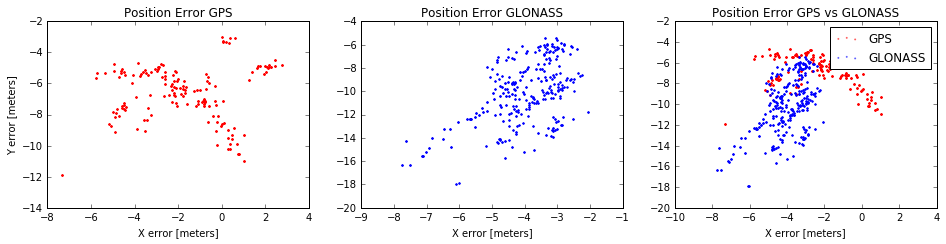

In [21]:
#fig=plt.figure(figsize=(8,8))
fig =plt.figure(figsize=(13,6))
fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)

plt.subplot(231)
plt.scatter(posXYGPS.X,posXYGPS.GPS, s=1, alpha=0.5, color = 'red')
plt.ylabel('Y error [meters]')
plt.xlabel('X error [meters]')
plt.title('Position Error GPS')

plt.subplot(232)
plt.scatter(posXYGlo.X,posXYGlo.GLONASS, s=1, alpha=0.5, color = 'blue')
plt.xlabel('X error [meters]')
plt.title('Position Error GLONASS')

plt.subplot(233)
plt.scatter(posXYGPS.X,posXYGPS.GPS, s=1, alpha=0.5, color = 'red')
plt.scatter(posXYGlo.X,posXYGlo.GLONASS, s=1, alpha=0.5, color = 'blue')
plt.xlabel('X error [meters]')
plt.title('Position Error GPS vs GLONASS')
plt.legend()
plt.show()

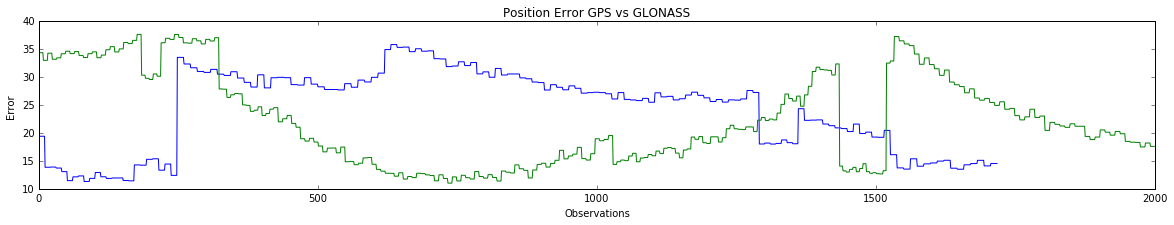

In [22]:
fig=plt.figure(figsize=(20,3))
plt.plot(erroresGPS) #Blue  GPS
plt.plot(erroresGlo) #Green GLONASS
plt.ylabel("Error ")
plt.xlabel("Observations")
plt.title('Position Error GPS vs GLONASS')

### Position for <font color='blue'>GPS</font> <font color='red'> +</font> <font color='blue'> GLONASS</font> -  <font color='red'>All Observations</font>


In [23]:
positionAll = []
erroresAll = []
c = 299792458.
SumError = 0.
vistos = []
ElevationsR = []
posXYAll = []

for i in range (0, observations):
    #print A_GPS.PRN[i]
    p1 = np.array(A_Glonass.P1[i]+A_GPS.P1[i])
    pos = np.array(A_Glonass.POS[i]+A_GPS.POS[i])
    clock = np.array(A_Glonass.CLOCK[i]+A_GPS.CLOCK[i])
    vistos.append(len(A_Glonass.PRN[i]+A_GPS.PRN[i]))
    
    ElevationsR.append(A_Glonass.ELEV[i]+A_GPS.ELEV[i])
    
    #del GloSat[2]
    #del GloP1[2]
    #del GloPos[2]
    #del GloClockBias[2]

    ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)
    
    
    pos_cpu = ls_computed_pos[:3]
    ls_error = np.linalg.norm(ls_computed_pos[:3] - real_pos)
    if ls_error<10000.: #quitar los errores de posición superiores a 10mil 
        posXYAll.append([ls_computed_pos[:1]-real_pos[:1],ls_computed_pos[1:2]-real_pos[1:2]])
        reciverBias = ls_computed_pos[3]/c
        SumError += ls_error
        positionAll.append([pos_cpu,ls_error,reciverBias])
        erroresAll.append(ls_error)
    else:
        sumaErroresMayoDiezmil += 1
        
names=["X","Both" ]
posXYAll = pd.DataFrame(posXYAll, columns=names)
print "Average Error Position for GLONASS: ", SumError/observations, "[meters]"
print "Maximum Error: ",max(erroresAll), "[meters]"
print "Minimum Error: ",min(erroresAll), "[meters]"

names = ["PosComputed","PosError","ClockBias"]
positionAll = pd.DataFrame(positionAll,columns=names)

Average Error Position for GLONASS:  19.3418654762 [meters]
Maximum Error:  31.4906629901 [meters]
Minimum Error:  14.7054654127 [meters]


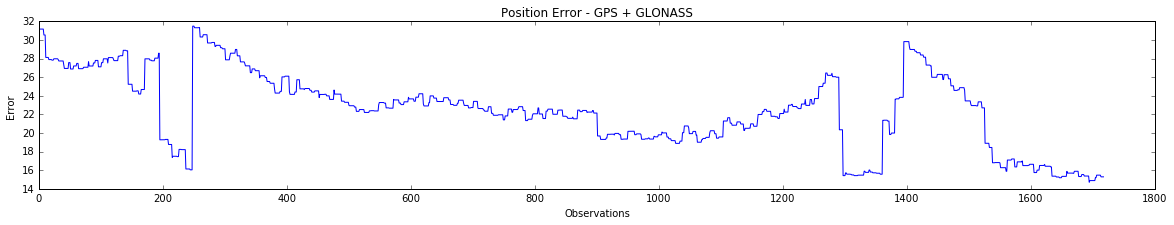

In [24]:
fig=plt.figure(figsize=(20,3))
plt.plot(erroresAll)
plt.ylabel("Error ")
plt.xlabel("Observations")
plt.title('Position Error - GPS + GLONASS')

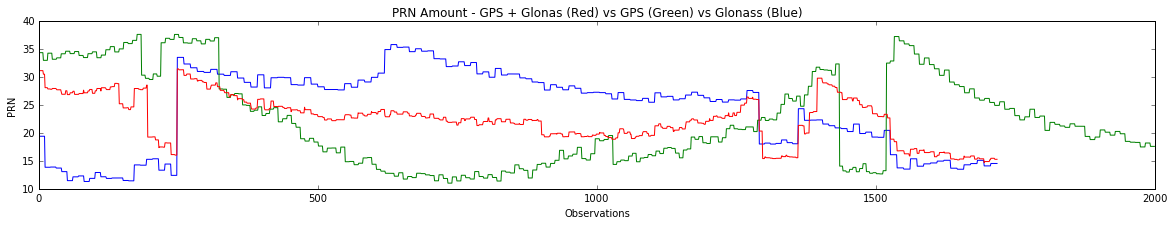

In [29]:
fig=plt.figure(figsize=(20,3))
plt.plot(erroresGPS) #Blue  GPS
plt.plot(erroresGlo) #Green GLONASS
plt.plot(erroresAll)#Red GPS + GLONASS
plt.ylabel("PRN")
plt.xlabel("Observations")
plt.title('PRN Amount - GPS + Glonas (Red) vs GPS (Green) vs Glonass (Blue)')

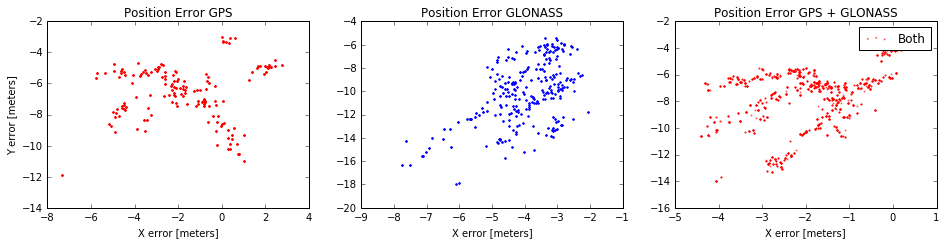

In [26]:
#fig=plt.figure(figsize=(8,8))
fig =plt.figure(figsize=(13,6))
fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)

plt.subplot(231)
plt.scatter(posXYGPS.X,posXYGPS.GPS, s=1, alpha=0.5, color = 'red')
plt.ylabel('Y error [meters]')
plt.xlabel('X error [meters]')
plt.title('Position Error GPS')

plt.subplot(232)
plt.scatter(posXYGlo.X,posXYGlo.GLONASS, s=1, alpha=0.5, color = 'blue')
plt.xlabel('X error [meters]')
plt.title('Position Error GLONASS')

plt.subplot(233)
plt.scatter(posXYAll.X,posXYAll.Both, s=1, alpha=0.5, color = 'red')
plt.xlabel('X error [meters]')
plt.title('Position Error GPS + GLONASS')
plt.legend()
plt.show()